In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
data_dir = '../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
train_dir = data_dir + '/train'
val_dir = data_dir +'/valid'

In [ ]:
def df_info(path):
    img_paths = []
    img_dirs = []
    img_size = []
    img_channel = []
    img_type = []
    plants = []
    category = []
    disease_list = []
    for file_path, dirs, filenames in os.walk(path,topdown=False):
        img_dirs = dirs
        for filename in filenames:

            full_path = file_path + '/' + filename

            img_paths.append(full_path)
            
            try:
                width, height, channels = plt.imread(full_path).shape
            except:
                width, height = plt.imread(full_path).shape
                channels = 1
            
            img_size.append(str(width) + 'x' + str(height))
            
            img_channel.append(channels)

            img_type.append(filename.split('.')[-1])

            plants.append(file_path.split('/')[-1].split('___')[0])

            cat = file_path.split('/')[-1].split('___')[1]
            category.append(cat)

            disease_list.append(int(cat != 'healthy'))

    df_info = pd.DataFrame.from_dict({'plant': plants, 'category': category, 'disease': disease_list, 'img_size': img_size, 
                                      'type': img_type, 'channels': img_channel, 'path': img_paths})
    
    df_count = pd.DataFrame(df_info.groupby(['plant', 'category']).size())
    df_count.rename(columns={0: 'img_count'}, inplace=True)
    df_count.reset_index(inplace=True)
    
    return df_info, df_count

In [ ]:
%%time
df_train_info, df_train_count = df_info(train_dir)
df_val_info, df_val_count = df_info(val_dir)

In [ ]:
df_train_info.shape[0], df_val_info.shape[0]

In [ ]:
len(df_train_info.plant.unique())

In [ ]:
df_train_info['img_size'].unique()

In [ ]:
df_train_info.channels.unique()[0], df_val_info.channels.unique()[0]

In [ ]:
n_cols = 5
list_plants = df_train_info.plant.unique()

for plant in list_plants:
    list_diseases = df_train_info.category[df_train_info.plant == plant].unique()
    n = len(list_diseases) // n_cols
    m = len(list_diseases) % n_cols

    if n_cols > len(list_diseases):
        n_rows = n + 1
    elif m == 0:
        n_rows = n
    elif m != 0:
        n_rows = n + 1

    fig = plt.figure(figsize=(15, 5), constrained_layout=False)
    fig.suptitle(plant, fontsize=15)
    
    i = 1
    for disease in list_diseases:
        f_ax = fig.add_subplot(n_rows, n_cols, i)
        i += 1
        f_ax.set_title(disease)
        plt.xticks([])
        plt.yticks([])
        img = plt.imread(df_train_info.loc[(df_train_info.plant == plant) & (df_train_info.category == disease), 'path'].sample(1).values[0])
        plt.imshow(img)
    fig.tight_layout()
    fig.savefig(f'{plant}_{disease}_{i}.jpg')

In [ ]:
num_train, num_val = (df_train_count.img_count.sum(), df_val_count.img_count.sum())

num_healthy_train, num_diseased_train = (df_train_count.img_count[df_train_count.category == 'healthy'].sum(), 
                             df_train_count.img_count[df_train_count.category != 'healthy'].sum())

num_healthy_val, num_diseased_val = (df_val_count.img_count[df_val_count.category == 'healthy'].sum(), 
                             df_val_count.img_count[df_val_count.category != 'healthy'].sum())

In [ ]:
fig1 = plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.title('Train/Valid Dataset distribution', fontsize=15)
plt.pie([num_train, num_val], explode=(0.05, 0), labels=['Train Set', 'Valid Set'], colors=['violet', 'turquoise'], 
        autopct='%1.1f%%')

plt.subplot(1, 3, 2)
plt.title('Train Dataset - healthy VS diseased plants', fontsize=15)
plt.pie([num_healthy_train, num_diseased_train], explode=(0.05, 0), labels=['Healthy', 'Diseased'], colors=['lavender', 'lightblue'],
        autopct='%1.1f%%')


plt.subplot(1, 3, 3)
plt.title('Val Dataset - healthy VS diseased plants', fontsize=15)
plt.pie([num_healthy_val, num_diseased_val], explode=(0.05, 0), labels=['Healthy', 'Diseased'], colors=['lavender', 'lightblue'],
        autopct='%1.1f%%')
fig1.savefig(f'plot_pie.jpg')
plt.show()

In [ ]:
def plot_category_distribution(df, subplot=1):
    indexes = df.img_count.index
    plt.subplot(2, 1, subplot)
    plt.bar(indexes, df.img_count.values, width=0.5, color='teal')
    plt.xlabel('Plants/Disease')
    plt.ylabel('Number of images')
    plt.xticks(indexes, df.plant, fontsize=10, rotation=90)

In [ ]:
fig2 = plt.figure(figsize=(15, 12))
plot_category_distribution(df_train_count, 1)
plt.title('Number of images per each category (diseased or healthy) of plants in Train Dataset', fontsize=15)
plt.subplots_adjust(hspace = 1)
plot_category_distribution(df_val_count, 2)
plt.title('Number of images per each category (diseased or healthy) of plants in Val Dataset', fontsize=15)
fig2.savefig(f'plot_distr.jpg')
plt.show()

In [4]:
train = ImageFolder(train_dir, transform=transforms.ToTensor())
val = ImageFolder(val_dir, transform=transforms.ToTensor())

In [5]:
len(train), len(val)

(70295, 17572)

In [6]:
img, label = train[10000]

In [7]:
img.shape, label, len(train.classes)

(torch.Size([3, 256, 256]), 5, 38)

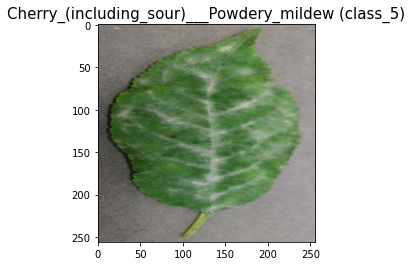

In [8]:
plt.title(f'{train.classes[label]} (class_{label})', fontsize=15)
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [9]:
BATCH_SIZE = 64

In [10]:
train_dl = DataLoader(train, BATCH_SIZE, shuffle=True, num_workers=2)
val_dl = DataLoader(val, BATCH_SIZE, num_workers=2)

In [11]:
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

In [12]:
class ResNet9(nn.Module):
    def __init__(self, in_channels, n_classes):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True)
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True)
        self.conv4 = ConvBlock(256, 512, pool=True)
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.Dropout(p=0.2),
                                        nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, n_classes)
                                       )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [13]:
model = ResNet9(3, len(train.classes)).to(device)
max_lr = 0.01
EPOCHS = 2
optimizer = optim.Adam(model.parameters(), lr=max_lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=EPOCHS, steps_per_epoch=len(train_dl))
loss_function = nn.CrossEntropyLoss()

In [14]:
def forward_pass(batch_imgs, batch_lbls):
    model.train()
        
    outputs = model(batch_imgs)
        
    loss = loss_function(outputs, batch_lbls)
        
    preds = torch.max(outputs, dim=1)[1]
    matches = preds == batch_lbls
    acc = float(torch.sum(matches.long())) / len(matches)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    scheduler.step()
    
    return acc, float(loss)

In [15]:
def validate(batch, last_batch=False):
    batch_imgs, batch_lbls = batch
    batch_imgs, batch_lbls = batch_imgs.to(device), batch_lbls.to(device)
    outputs = model(batch_imgs)
    
    val_loss = loss_function(outputs, batch_lbls)
    
    preds = torch.max(outputs, dim=1)[1]
    
    matches = preds == batch_lbls
    val_acc = float(torch.sum(matches.long())) / len(matches)
    
    if last_batch:
        return {'val_acc': val_acc, 'val_loss': float(val_loss), 'batch_lbls': batch_lbls.cpu().numpy(), 'batch_preds': preds.cpu().numpy()}
    
    return {'val_acc': val_acc, 'val_loss': float(val_loss)}

In [16]:
def evaluate(model, val_loader, last_batch=False):
    model.eval()
    with torch.no_grad():
        val_evals = [validate(batch, last_batch) for batch in val_loader]
    
    if last_batch:
        return (np.mean([x['val_acc'] for x in val_evals]), np.mean([x['val_loss'] for x in val_evals]), 
               np.hstack([x['batch_lbls'] for x in val_evals]), np.hstack([x['batch_preds'] for x in val_evals]))
        
    return np.mean([x['val_acc'] for x in val_evals]), np.mean([x['val_loss'] for x in val_evals])

In [17]:
def plot_cnfsn_mtrx(lbls, preds):
    act_classes = [train.classes[lbls[i]] for i in range(len(lbls))]
    pred_classes = [train.classes[preds[i]] for i in range(len(preds))]

    df_cls = pd.DataFrame({'actual': act_classes, 'predicted': pred_classes})

    cnf_mtrx = pd.crosstab(df_cls.actual, df_cls.predicted, rownames=['actual'], colnames=['predicted'])

    fig3, ax = plt.subplots(figsize=(10, 8))
    plt.title('Confusion matrix', fontsize=15)
    sns.heatmap(cnf_mtrx, annot=True, cmap='BuGn', ax=ax)
    fig3.savefig(f'confusion_matrix.jpg')
    plt.show()

In [18]:
def model_train():
    with open('model_resnet9.log', 'a') as f:
        
        for epoch in range(1, EPOCHS + 1):
            lrs = []
            i = 0
            for batch in train_dl:
                i += 1
                batch_imgs, batch_lbls = batch
                batch_imgs, batch_lbls = batch_imgs.to(device), batch_lbls.to(device)
                
                acc, loss = forward_pass(batch_imgs, batch_lbls)
                
                lr = [param_group['lr'] for param_group in optimizer.param_groups]
                lrs.append(lr)
                
                if epoch == EPOCHS and i == len(train) // BATCH_SIZE:
                    
                    val_acc, val_loss, lbls, preds = evaluate(model, val_dl, last_batch=True)
                    
                    f.write(f"{int(i // (BATCH_SIZE / 2) + 1)},{round(float(acc), 2)},{round(float(loss), 4)}, {round(float(val_acc), 4)},{round(float(val_loss), 4)}\n")
                    
                if i % (BATCH_SIZE / 2) == 0:
                            
                    val_acc, val_loss = evaluate(model, val_dl)
                            
                    f.write(f"{int(i / (BATCH_SIZE / 2))},{round(float(acc), 2)},{round(float(loss), 4)}, {round(float(val_acc), 4)},{round(float(val_loss), 4)}\n")
    return lbls, preds, lrs

In [19]:
%%time
lbls, preds, lrs = model_train()

CPU times: user 1h 22min 38s, sys: 4min 22s, total: 1h 27min
Wall time: 1h 35min 10s


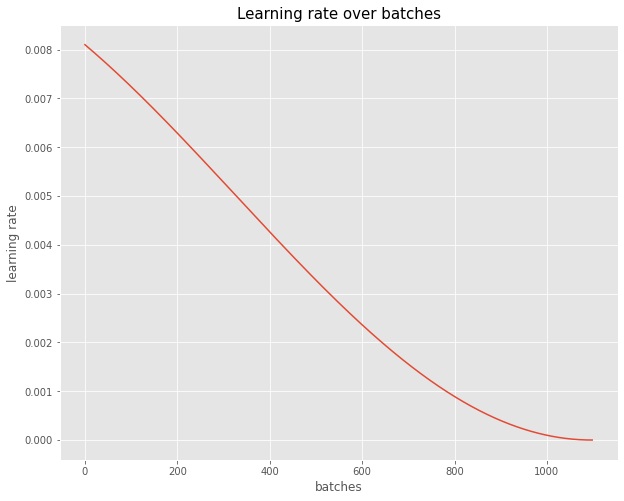

In [36]:
fig5 = plt.figure(figsize=(10, 8))
plt.plot(lrs)
plt.xlabel('batches')
plt.ylabel('learning rate')
plt.title('Learning rate over batches', fontsize=15)
fig5.savefig(f'cycle_lrs.jpg')
plt.show()

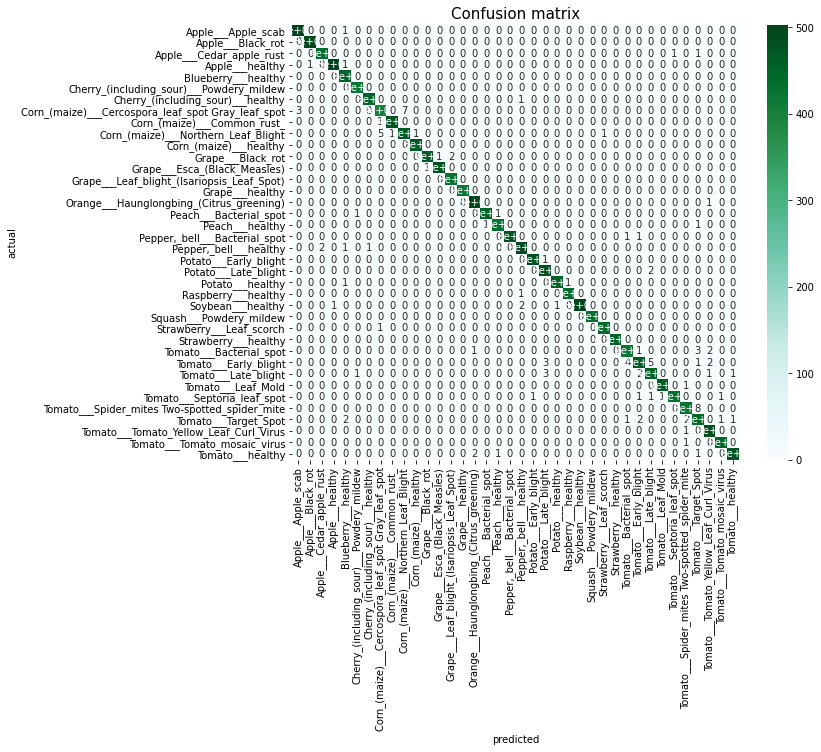

In [25]:
plot_cnfsn_mtrx(lbls, preds)

In [35]:
from sklearn.metrics import classification_report

print(classification_report(lbls, preds))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       504
           1       1.00      1.00      1.00       497
           2       1.00      1.00      1.00       440
           3       1.00      1.00      1.00       502
           4       0.99      1.00      0.99       454
           5       1.00      1.00      1.00       421
           6       1.00      1.00      1.00       456
           7       0.98      0.98      0.98       410
           8       1.00      1.00      1.00       477
           9       0.99      0.98      0.98       477
          10       1.00      1.00      1.00       465
          11       1.00      0.99      1.00       472
          12       1.00      1.00      1.00       480
          13       1.00      1.00      1.00       430
          14       1.00      1.00      1.00       423
          15       0.99      1.00      1.00       503
          16       1.00      1.00      1.00       459
          17       1.00    

In [45]:
report_table = classification_report(lbls, preds, target_names=val.classes, output_dict=True)
report_df = pd.DataFrame(report_table).T

,precision,recall,f1-score,support
Apple___Apple_scab,0.994071,0.998016,0.996040,504.00000
Apple___Black_rot,0.997992,1.000000,0.998995,497.00000
Apple___Cedar_apple_rust,0.995455,0.995455,0.995455,440.00000
Apple___healthy,0.998004,0.996016,0.997009,502.00000
Blueberry___healthy,0.986957,1.000000,0.993435,454.00000
Cherry_(including_sour)___Powdery_mildew,0.995272,1.000000,0.997630,421.00000
Cherry_(including_sour)___healthy,0.997807,0.997807,0.997807,456.00000
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,0.982801,0.975610,0.979192,410.00000
Corn_(maize)___Common_rust_,0.997904,0.997904,0.997904,477.00000
Corn_(maize)___Northern_Leaf_Blight,0.985294,0.983229,0.984260,477.00000


In [48]:
report_df.precision.mean(), report_df.recall.mean(), report_df['f1-score'].mean()

(0.9937196818319737, 0.9936901530751583, 0.9936970104379221)

In [26]:
file_name = 'model_resnet9.log'
file_dir = './'


contents = open(os.path.join(file_dir + file_name), 'r').read().split('\n')
vals_losses = [{'num': float(x.split(',')[0]), 'acc': float(x.split(',')[1]), 'loss': float(x.split(',')[2]),
                'val_acc': float(x.split(',')[3]), 'val_loss': float(x.split(',')[4])} for x in contents if x != '']
df_vals_losses = pd.DataFrame(vals_losses)

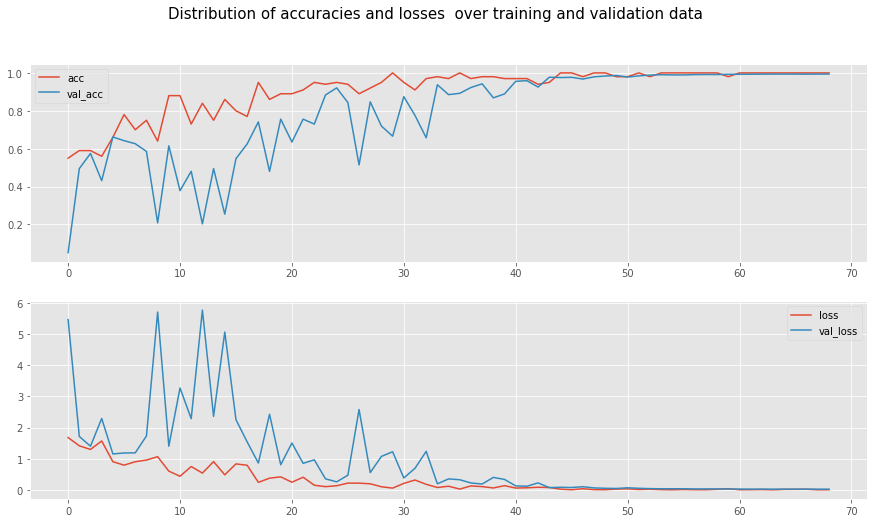

In [27]:
from matplotlib import style
style.use('ggplot')
fig4 = plt.figure(figsize=(15, 8))
fig4.suptitle('Distribution of accuracies and losses  over training and validation data', fontsize=15)

ax1 = plt.subplot2grid((2, 1), (0, 0))
ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)

ax1.plot(df_vals_losses.acc, label='acc')
ax1.plot(df_vals_losses.val_acc, label='val_acc')
ax1.legend()

ax2.plot(df_vals_losses.loss, label='loss')
ax2.plot(df_vals_losses.val_loss, label='val_loss')
ax2.legend()
fig4.savefig(f'acc_loss_distr.jpg')
plt.show()

In [28]:
print(f"Validation loss of the model: {df_vals_losses.val_loss.iloc[-1]}, validation accuracy of the model: {df_vals_losses.val_acc.iloc[-1]}")

Validation loss of the model: 0.0241, validation accuracy of the model: 0.9938


In [29]:
test_dir = '../input/new-plant-diseases-dataset/test'
test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [30]:
test_imgs = sorted(os.listdir(test_dir + '/test'))

In [31]:
def pred_img(img, model):
    model.eval()
    with torch.no_grad():
        output = model(img.unsqueeze(0).to(device))
        class_ind = torch.max(output, dim=1)[1][0].item() # torch.max(output, dim=1)[0].item()???
    return train.classes[class_ind]

In [32]:
for i, (img, _) in enumerate(test):
    print(f"label: {test_imgs[i]}    predicted: {pred_img(img, model)}")

label: AppleCedarRust1.JPG    predicted: Apple___Cedar_apple_rust
label: AppleCedarRust2.JPG    predicted: Apple___Cedar_apple_rust
label: AppleCedarRust3.JPG    predicted: Apple___Cedar_apple_rust
label: AppleCedarRust4.JPG    predicted: Apple___Cedar_apple_rust
label: AppleScab1.JPG    predicted: Apple___Apple_scab
label: AppleScab2.JPG    predicted: Apple___Apple_scab
label: AppleScab3.JPG    predicted: Apple___Apple_scab
label: CornCommonRust1.JPG    predicted: Corn_(maize)___Common_rust_
label: CornCommonRust2.JPG    predicted: Corn_(maize)___Common_rust_
label: CornCommonRust3.JPG    predicted: Corn_(maize)___Common_rust_
label: PotatoEarlyBlight1.JPG    predicted: Potato___Early_blight
label: PotatoEarlyBlight2.JPG    predicted: Potato___Early_blight
label: PotatoEarlyBlight3.JPG    predicted: Potato___Early_blight
label: PotatoEarlyBlight4.JPG    predicted: Potato___Early_blight
label: PotatoEarlyBlight5.JPG    predicted: Potato___Early_blight
label: PotatoHealthy1.JPG    predi

In [33]:
path = './plant-disease-ResNet9-2epch-sched-model.pth'  
torch.save(model.state_dict(), path)